In [1]:
!date

Thu Jul 13 06:36:59 EDT 2023


In [2]:
pwd

'/mmfs1/data/aglinska/BC-actionpred-seg/twostream_feafa'

In [3]:
import torch
from torch.nn import functional as F
from torch import nn
from typing import Union
import numpy as np
from math import exp
import os
from os import listdir
from os.path import isfile, join
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from torchvision import models
import torch.optim as optim
import gc

from importlib import reload

import feafa_utils
import feafa_dataloader
import feafa_architecture
import feafa_criterion

reload(feafa_utils)
reload(feafa_dataloader)
reload(feafa_architecture)
reload(feafa_criterion)

<module 'feafa_criterion' from '/mmfs1/data/aglinska/BC-actionpred-seg/twostream_feafa/feafa_criterion.py'>

In [15]:
print(torch.__version__)
print(torch.__file__)

1.13.1+cu117
/data/aglinska/anaconda3/lib/python3.8/site-packages/torch/__init__.py


In [4]:
from matplotlib import pyplot as plt
from tqdm import tqdm

In [5]:
def safe_mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
# # no lbls
# path = '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_orig/train/'
# window = 11
# traindataset = feafa_dataloader.FeafaDataset(path,window,usage='Train')
# trainloader = DataLoader(traindataset,batch_size = 32)
# len(trainloader)

In [8]:
# lbls?
path = '/data/aglinska/BC-actionpred-seg/Data/pytorch-data/xl_121_15_action_data_orig/train/'
window = 11
traindataset = feafa_dataloader.FeafaDataset(path,window,usage='Train',return_labels=True)
trainloader = DataLoader(traindataset,batch_size = 32)
len(trainloader)

2340

In [9]:
# Load network and reconstuctor
save_root = "/data/aglinska/BC-actionpred-seg/Data/02-results_twostream_feafa_2/epoch00005.ckp"
flownet = feafa_architecture.TinyMotionNet()
flownet.load_state_dict(torch.load(save_root)['model_state_dict'])
reconstructor = feafa_utils.Reconstructor()

In [10]:
# h.save({
#             'epoch': epoch,
#             'model_state_dict': flownet.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': epoch_loss,
#             'loss_collect' : loss_collect
#             }, save_path)

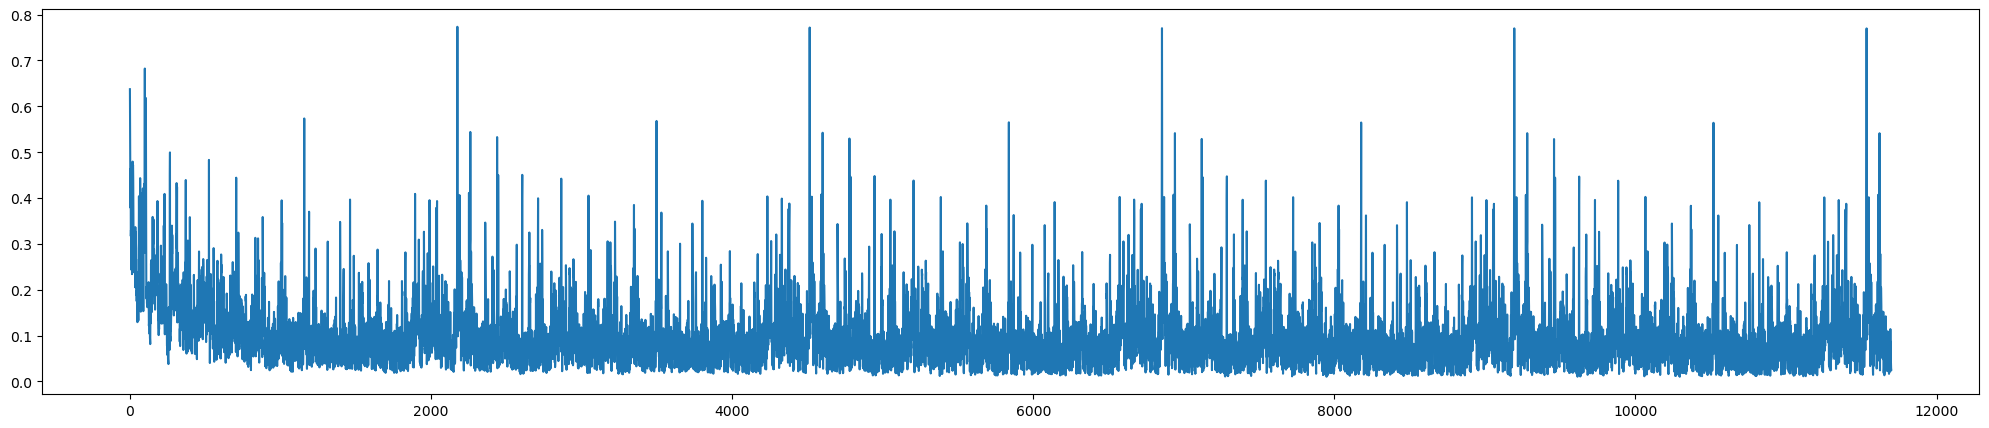

In [11]:
plt.figure(figsize=(25,5))
plt.plot(torch.load(save_root)['loss_collect'])

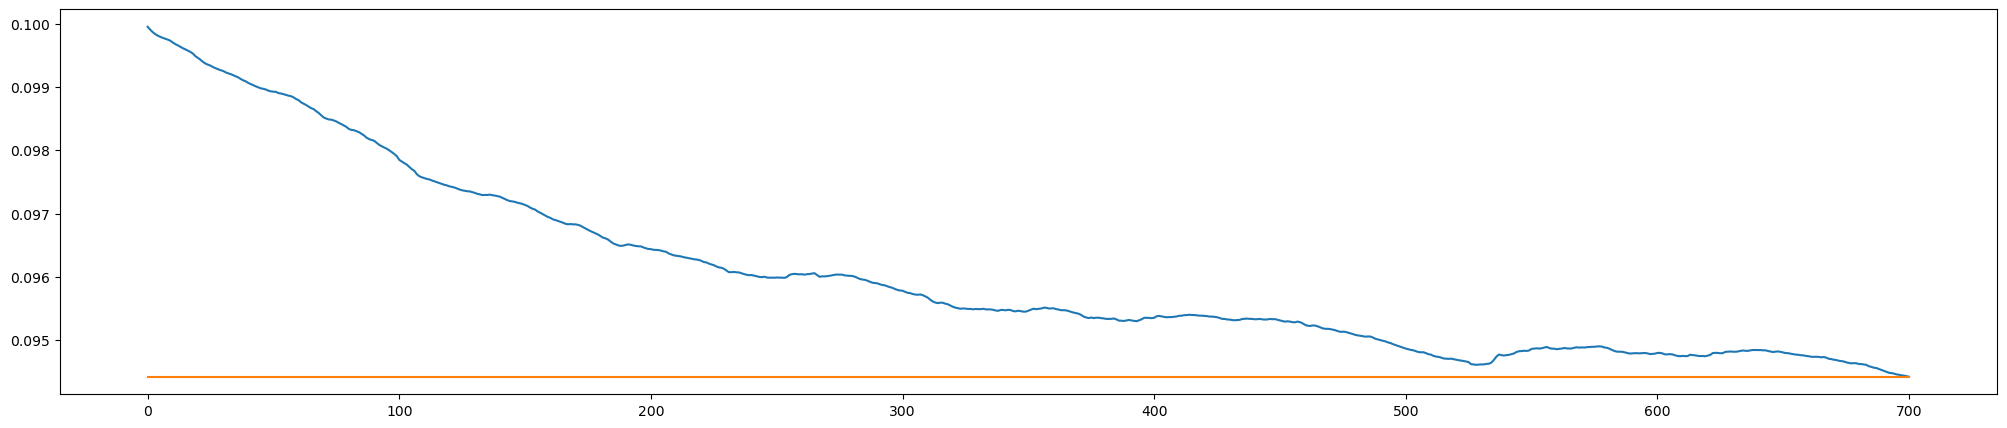

In [12]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
plt.figure(figsize=(25,5))
y = moving_average(x=torch.load(save_root)['loss_collect'], w=11000)
plt.plot( y )
plt.plot(np.arange(len(y)),np.ones(len(y))*y.min())

In [32]:
# Prep save dir
out_dir = '~/BC-actionpred-seg/Data/pytorch-data/flows/train'
out_dir = os.path.expanduser(out_dir)
safe_mkdir(out_dir)

In [33]:
# for i in tqdm( range(len(traindataset)) ):
#     sample = traindataset.__getitem__(index=i,return_labels=True)

#     frames = sample['frames']
#     labels = sample['labels']

#     frames = frames[np.newaxis,:,:,:,:]
#     pred = flownet(frames)

#     t0s, reconstructed, flows_reshaped = reconstructor(frames.cuda(),[val.cuda() for val in pred])

#     safe_mkdir(os.path.join(out_dir,labels[0][0]))

#     flows_out = flows_reshaped[0] # 10x2x224x244
#     flows_out = flows_out.cpu().detach().numpy()[0,:,:,:] #10x2x224x244

#     out_fn = os.path.join(out_dir,labels[0][0],labels[0][1].replace('.jpg','.npy'))

#     np.save(file=out_fn, arr=flows_out)

In [34]:
i = 0

(-0.5, 223.5, 223.5, -0.5)

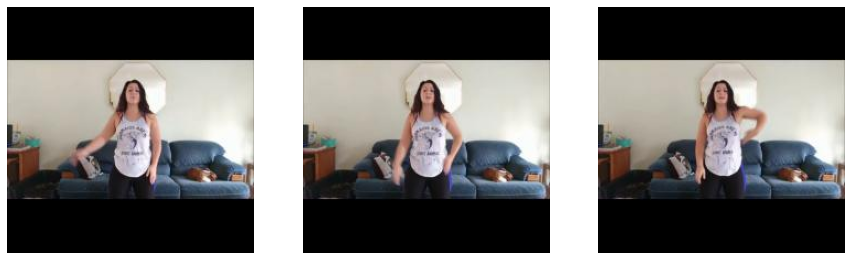

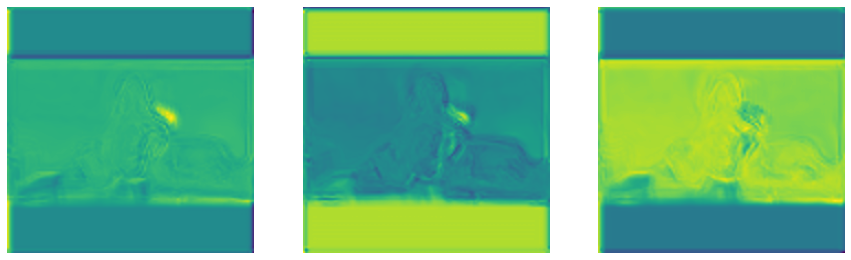

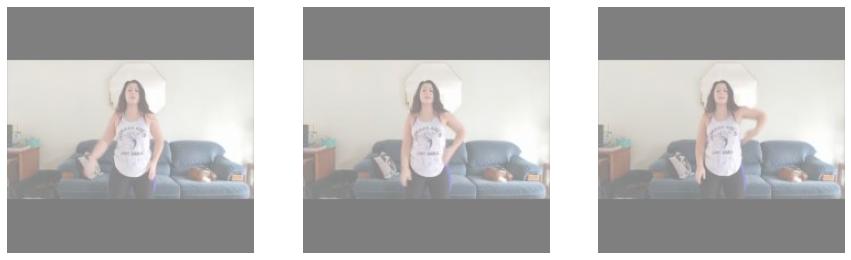

In [35]:
#i = i+1000
i = 2600

sample = traindataset.__getitem__(i)

frames = sample['frames']
labels = sample['labels']

pred = flownet(frames[np.newaxis,:,:,:,:])

reconstructor = feafa_utils.Reconstructor()
frames2 = frames[np.newaxis,:,:,:,:]
frames2 = frames2.cuda()
t0s, reconstructed, flows_reshaped = reconstructor(frames2,[val.cuda() for val in pred])

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(frames[:,0,:,:].detach().numpy().swapaxes(0,1).swapaxes(1,2))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(frames[:,4,:,:].detach().numpy().swapaxes(0,1).swapaxes(1,2))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(frames[:,10,:,:].detach().numpy().swapaxes(0,1).swapaxes(1,2))
plt.axis('off')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(flows_reshaped[0][0,1,:,:].detach().cpu())
#plt.imshow( flows_reshaped[0][0,:,:,:].detach().cpu().mean(axis=0) )
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(flows_reshaped[0][4,1,:,:].detach().cpu())
#plt.imshow( flows_reshaped[0][5,:,:,:].detach().cpu().mean(axis=0) )
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(flows_reshaped[0][9,1,:,:].detach().cpu())
#plt.imshow( flows_reshaped[0][-1,:,:,:].detach().cpu().mean(axis=0) )
plt.axis('off')


plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(reconstructed[0].cpu().detach().numpy()[1,:,:,:].swapaxes(0,1).swapaxes(1,2))
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(reconstructed[0].cpu().detach().numpy()[5,:,:,:].swapaxes(0,1).swapaxes(1,2))
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(reconstructed[0].cpu().detach().numpy()[-1,:,:,:].swapaxes(0,1).swapaxes(1,2))
plt.axis('off')

In [ ]:
for i in tqdm( range(len(traindataset)) ):
    sample = traindataset.__getitem__(index=i,return_labels=True)

    frames = sample['frames']
    labels = sample['labels']

    frames = frames[np.newaxis,:,:,:,:]
    pred = flownet(frames)

    t0s, reconstructed, flows_reshaped = reconstructor(frames.cuda(),[val.cuda() for val in pred])

    safe_mkdir(os.path.join(out_dir,labels[0][0]))

    flows_out = flows_reshaped[0] # 10x2x224x244
    flows_out = flows_out.cpu().detach().numpy()[0,:,:,:] #10x2x224x244

    out_fn = os.path.join(out_dir,labels[0][0],labels[0][1].replace('.jpg','.npy'))

    np.save(file=out_fn, arr=flows_out)

  1%|          | 872/74862 [03:44<5:22:40,  3.82it/s]

In [17]:
print(pred[0].detach().numpy().shape)
print(pred[1].detach().numpy().shape)
print(pred[2].detach().numpy().shape)
print(pred[3].detach().numpy().shape)

(1, 20, 224, 224)
(1, 20, 112, 112)
(1, 20, 56, 56)
(1, 20, 28, 28)
